##### Copyright 2020 The EvoFlow Authors.

In [27]:
#@title Licensed under the Apache License, Version 2.0 & Creative Common licence 4.0
# EvoFlow and its tutorials are released under the Apache 2.0 licence
# its documentaton is licensed under the Creative Common licence 4.0

# EvoFlow hello world: OneMax

This notebook provide a quick introduction of how EvoFlow works by showing how you can use to solve the [classic *OneMax* problem with it](http://www.cs.cmu.edu/~02317/slides/lec_8.pdf).

At its core <b>EvoFlow is a modern hardware accelerated genetic algorithm framework that recast genetic algorithm programing as a dataflow computation on tensors</b>. Conceptually is very similar to what `Tensorflow.keras` is doing so if you have experience with Keras or Tensorflow you will feel right at home. Under the hood, EvoFlow leverage Tensorflow or Cupy to provide hardware accelerated operations.


For more information about EvoFlow design and architecture, see our paper.

<b>EvoFlow, while heavily tested, is considered experimental - use at your own risks. Issues should be reported on [Github](https://github.com/google-research/evoflow/issues). For the rest: evoflow@google.com</b>

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-research/evoflow/blob/master/notebooks/onemax.ipynb"><img src="https://storage.googleapis.com/evoflow/images/colab.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google-research/evoflow/blob/master/notebooks/onemax.ipynb"><img src="https://storage.googleapis.com/evoflow/images/github.png"  />View source on GitHub</a>
  </td>
</table>

## Setup

In [28]:
# installing the latest version of evoflow
try:
    import evoflow
except:
    !pip install -U evoflow
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_extautoreload


In [29]:
from evoflow.engine import EvoFlow
from evoflow.selection import SelectFittest
from evoflow.population import randint_population
from evoflow.fitness import Sum
from evoflow.ops import Input, RandomMutations1D, UniformCrossover1D

## Population definition
In this example, we are going to represent the population as a 2D tensor where:

- the 1st dimension is the number of chromosome (population)
- the 2nd dimension is the number of gene per chromosome.

In [30]:
POPULATION_SIZE = 64  #@param {type: "slider", min: 16, max: 2048}
CHROMOSOME_SIZE = 32  #@param {type: "slider", min: 16, max: 2048}

SHAPE = (POPULATION_SIZE, CHROMOSOME_SIZE)
print(f"Population will have {SHAPE[0]} distinct chromosomes made of {SHAPE[1]} genes")

Population will have 64 distinct chromosomes made of 32 genes


Our model need an initial population to mutate as inputs. Here, we are taking the traditional approach to initialize this population at random while ensure the gene value is either 0 or 1 by setting the `max_value` to `1`. We will use the population in the `evolve()` funtion very similarly that you would feed your `x_train` data in deep-learning.

In [31]:
population = randint_population(SHAPE, max_value=1)

## Evolution model setup

Building an evolution model requires setup the <i>evolution operations</i> and then compiling the model.

Genetic operations are represented by `OPs` that are very similar to the [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers). They are combined by creating a directed graph that inter-connect them, again very similarly to what the keras functional API is doing.

In this example we will mutate our population using two very basic genetic algorithm operations: the Random Mutation and Uniform Crossover. As our population is made of single dimensions chromosomes we will use the 1D variant of those ops: `RandomMutations1D` and `UniformCrossover1D`.

You can experiment using a 2D or even a 3D population by changing the input shape above and using operation variants that match your chromosomes shape. For example you need to use `UniformCrossover2D` for a 2D population, and `UniformCrossover3D` for a 3D population.

In [32]:
inputs = Input(shape=(SHAPE))
x = RandomMutations1D(max_gene_value=1, min_gene_value=0)(inputs)
outputs = UniformCrossover1D()(x)

We instantiate our model by providing its inputs and outputs. Under the hood a EvoFlow model is represented as a direct graph that support multiples inputs, multiple outputs, and arbitrary branching to tackle the most complex use-cases. You can use `summary()` to check what your model will look like.

In [33]:
ef = EvoFlow(inputs, outputs)
ef.summary()

OP (type)                                       Output Shape    Inputs
----------------------------------------------  --------------  ------------------------
input_FCED45 (Input)                            (64, 32)
randommutations1d_A88708 (RandomMutations1D)    []              input_FCED45
uniformcrossover1d_678891 (UniformCrossover1D)  []              randommutations1d_A88708


## Model compilation

Before the model is ready for evolutions, it needs two additional key components that will be supplied to the `compile` function:

- How to asses how good is a given chromosome (`fitness function`) 
- How to select chromosomes and renew the pool (`Selection function`)


### Fitness function

The [fitness function](https://en.wikipedia.org/wiki/Fitness_function) is the algorithm objective function that the model try to maximize. It is the most critical part of a genetic algorithm where you express the constraints that a chromosome must satisify to solve the problem. At each evolution this function is used to compute how fit for the task each chromosome are.


Fitness functions are very similar to loss functions in deep-learning except they don't need to be differentiable and therefore can perform arbitrary computation. Depending on the problem solved, you can decide to either maximize, minimize the fitness value or get it to converge to a fixed value. 

The cost of fitness function increased expressiveness and flexibility compared to neural network loss is that we don't have the gradients to help guide the model convergence and therefore coverging is more computationaly expensive.

To make things efficient and fast, it is recommended to implement Fitness functions in EvoFlow as tensor operations but this is not requireds as long as the function return at the end an 1D tensor that contains the fitness value for each chromosome in the population.

To solve the OneMax problem we want a fitness function that encourages the chromosomes to have as many genes with a value of 1 as possible. In tensor representation this is easy to acheive by simply computing the sum of the chromosome and using that value as its fitness. 

To make the progress look nicer, we scale the fitness between 0 and 1 by supplying a max_sum_value equivalent to CHROMOSOME_SIZE as the best case is a chromosome made only of 1s.

In [34]:
fitness_function = Sum(max_sum_value=CHROMOSOME_SIZE)

### Modeling evolutionary selection

The evolutionary process takes the fitness values and decides which chromosomes to keep. A naive form to model selection is to keep the fitest individuals and carry them over to the next generation. This is usualy referred as an [elitist selection strategy](https://en.wikipedia.org/wiki/Genetic_algorithm#Elitism). For instance, we can keep the fitest individuals (the one with the largest fitness values) as we create the next generation. 

Alternative functions that have different selection intensitive pressure properties exist. For example, [roulette wheel selection](https://en.wikipedia.org/wiki/Selection_(genetic_algorithm)#a._Roulette_Wheel_Selection) has non-constant selection intensity depending on the population's fitness distribution, whereas [tournament selection](https://en.wikipedia.org/wiki/Tournament_selection) provides constant selection intesity regardless of the fitness distribution.


In [35]:
selection_strategy = SelectFittest()

### Compilation
Now that we have defined our fitness_function and our selection_strategy, our model is ready to get compiled with those as parameters.

In [36]:
ef.compile(selection_strategy, fitness_function)

##  Evolution

We now are going to evolve our inital random population over a couple of generations. At each generation the evolution strategy keep the best invididuals and replace the low performing ones with the best one of the previous generation.

`generation=` controls the number of time the model is applied to the population to generate a new generation of mutated specimens. It is equivalent to what the number of epochs is deep-learning. The harder the problem, the more generations you need.

In [37]:
GENERATIONS = 4  #@param {type: "slider", min: 5, max: 100}

As the model evolve, look for the value of fitness_function_max which indicate the value of the best performing chromosome. As you will see it will quickly reach 1, which indicates that we found an optimal solution

In [38]:
results = ef.evolve(population, generations=GENERATIONS)

## Results

Let's check that the optimal solution we found are chromosomes fully made of 1s. 

First let's look at how quickly our model converged. Depending on  your population size and chromosomes size the convergence will be slower or faster. We encourage you to experiments with different values.

Note: in the graph below we use `static=True` to generate graph as .png and have them display in colab and github. However, when developping your own algorithms, we recommend using the interactive ones that rely on altair as it makes for a nicer experience :)

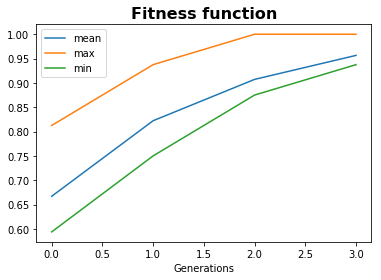

In [39]:
results.plot_fitness(static=True) # note we use a static display

Next we can look at what the population look like using a heatmap. As the model converged to the optimal solution the top chromosomes are all made of ones and form a uniform color band. If you evolve long enough the whole heatmap will be of a solid color as all the chromosomes will contains the optimial solution.

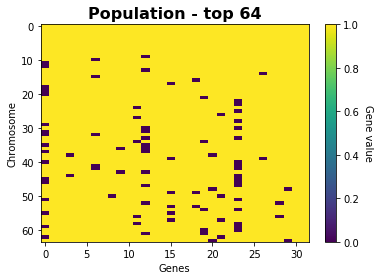

In [40]:
results.display_populations(top_k=100, rounding=0)

Finally to convince ourselves that EvoFlow worked as intended we can display the top 10 best solutions and check they are made of 1s

In [41]:
results.top_k()

fit score  genes [:20]
-----------  --------------------------------------------
    1        1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  ...
    1        1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  ...
    1        1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  ...
    1        1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  ...
    1        1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  ...
    1        1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  ...
    1        1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  ...
    1        1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  ...
    1        1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  ...
    0.96875  1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1  ...
